In [1]:
!conda init && conda activate makemore

no change     /home/igarg/miniconda3/condabin/conda
no change     /home/igarg/miniconda3/bin/conda
no change     /home/igarg/miniconda3/bin/conda-env
no change     /home/igarg/miniconda3/bin/activate
no change     /home/igarg/miniconda3/bin/deactivate
no change     /home/igarg/miniconda3/etc/profile.d/conda.sh
no change     /home/igarg/miniconda3/etc/fish/conf.d/conda.fish
no change     /home/igarg/miniconda3/shell/condabin/Conda.psm1
no change     /home/igarg/miniconda3/shell/condabin/conda-hook.ps1
no change     /home/igarg/miniconda3/lib/python3.12/site-packages/xontrib/conda.xsh
no change     /home/igarg/miniconda3/etc/profile.d/conda.csh
no change     /home/igarg/.bashrc
No action taken.

CondaError: Run 'conda init' before 'conda activate'



In [2]:
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
file_path = Path("names.txt").resolve()

In [4]:
if not file_path.is_file():
    raise FileNotFoundError(f"No file with the name {file_path} is present. Ensure that the file is present before proceeding")

In [5]:
with open(file_path, "r") as f:
    words = f.read().splitlines(keepends=False)

In [6]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

In [8]:
shape = (27, 27)


In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

In [10]:
# build the dataset

block_size = 3 # context length: no of chars needed prev to predict next char

X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [12]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((shape[0], 2), generator=g) # look-up table

In [ ]:
C[5]

tensor([-0.4713,  0.7868])

In [ ]:
import torch.nn.functional as F


F.one_hot(torch.tensor(5), num_classes=shape[0]).float() @ C

tensor([-0.4713,  0.7868])

In [15]:
emb = C[X]
emb[0]

tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373]])

In [16]:
num_neurons = 100

In [17]:
W1 = torch.randn((6, num_neurons)) # 6 = 3 * 2, i.e, for each, we have 2-dimensional neurons and 3 of them, 100 -> no. of neurons
b = torch.randn(num_neurons)

In [18]:
# need to do emb @ W1 + b

emb.shape, W1.shape # not multiplicable

(torch.Size([228146, 3, 2]), torch.Size([6, 100]))

In [19]:
# need to convert emb to (32, 6) -> need to squash dims 1 and 2
# naive way:
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape # plucks each row from the 2nd dimension and concats them to form shape (32, 6)

# disadvantage: does not scale if block size is changed

torch.Size([228146, 6])

In [20]:
# better way
# len(torch.unbind(emb, 1)) # unbinds the tensor at given dim, (in our case 1 , since (32, 3, 2)), and returns a tuple plucking from each index in said dim,
torch.cat(torch.unbind(emb, 1), 1).shape # now scalable across any block size

# disadvantageous: not efficient

torch.Size([228146, 6])

In [21]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [22]:
a.view((3, 3, 2))

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [23]:
a.storage(
) # way in which tensors are stored in memory, 1-D list of vectors

# when view is called, some attributes of the tensor shape, namely shapes and strides are manipulated

/tmp/ipykernel_2454/1209347448.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage(


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [24]:
# emb.view(32, 6) # squashes dims 1 and 2. exactly what we need
emb.view(emb.shape[0], 6) == torch.cat(torch.unbind(emb, 1), 1) # evaluates to all True

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [25]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b)

In [26]:
h.shape

torch.Size([228146, 100])

In [27]:
W2 = torch.randn((num_neurons, shape[0]))
b2 = torch.randn(shape[0])

In [28]:
h.shape, W2.shape

(torch.Size([228146, 100]), torch.Size([100, 27]))

In [29]:
logits = h @ W2 + b2
prob = torch.softmax(logits, 1)

In [30]:
logits.shape, prob.shape

(torch.Size([228146, 27]), torch.Size([228146, 27]))

In [31]:
Y, prob

(tensor([ 5, 13, 13,  ..., 26, 24,  0]),
 tensor([[2.4143e-10, 2.7450e-15, 2.6660e-15,  ..., 6.5016e-07, 2.7926e-09,
          4.4147e-09],
         [3.6202e-02, 2.4790e-05, 2.1292e-07,  ..., 8.1154e-04, 1.6614e-07,
          8.2539e-04],
         [2.9635e-14, 1.1084e-15, 1.3574e-10,  ..., 5.9451e-05, 8.1127e-13,
          1.0623e-12],
         ...,
         [9.1900e-08, 1.0903e-01, 2.1394e-07,  ..., 1.6538e-06, 2.0843e-10,
          1.3515e-08],
         [1.2056e-14, 8.6255e-11, 4.8791e-10,  ..., 1.2283e-03, 7.4418e-16,
          1.2908e-14],
         [2.2674e-08, 1.2957e-08, 4.6685e-09,  ..., 2.7137e-06, 9.0734e-05,
          1.9635e-08]]))

In [32]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(18.0847)

In [33]:
# reg_strength = .01
# reg_loss = reg_strength * (W2 ** 2).mean()
# loss += reg_loss
# loss

In [34]:
block_size = 3
dim_size = 2
num_neurons = 100
num_chars = 27


In [35]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [36]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((num_chars, dim_size), generator=g, requires_grad=True).float()
W1 = torch.randn((block_size * dim_size, num_neurons), generator=g, requires_grad=True).float()
b1 = torch.randn(num_neurons, generator=g, requires_grad=True)
W2 = torch.randn((num_neurons, num_chars), generator=g,  requires_grad=True).float()
b2 = torch.randn(num_chars, generator=g, requires_grad=True)
h = torch.tanh

# training params (hyperparameters)
reg_strength = 0.01
lr = .0005
num_steps = 10000
break_at = 1e-4
batch_size = 32

params = [C, W1, b1, W2, b2]

# num_params
print(sum((p.nelement()) for p in params))

3481


In [37]:
# choose a good lr
lre = torch.linspace(-3, 0, num_steps)
lrs = 10 ** lre

In [38]:
lrtoloss = {}
for i in range(num_steps):
    # minibatch
    ix = torch.randint(0, X.shape[0], (batch_size, ))
    yx = Y[ix]
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((emb.shape[0], block_size * dim_size)) @ W1 + b1)
    logits = h @ W2 + b2
    # prob = torch.softmax(logits, 1)
    # loss = -prob[torch.arange(Y.shape[0]), Y].log().mean() # nll
    prev_loss = loss
    loss = F.cross_entropy(logits, yx)
    reg_loss = reg_strength * (W2 ** 2).mean()
    loss += reg_loss
    # print(f"Step {i + 1}: Loss: {loss}")
    lr = 10**-5
    # lr = lrs[i]
    # lrtoloss[lre[i]] = loss.item()
    # if abs(prev_loss - loss) < break_at:
    #     print("Not enough loss happening, breaking...")
    #     break
    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    # update
    for p in params:
        p.data += -lr * p.grad


In [39]:
loss

tensor(15.0411, grad_fn=<AddBackward0>)

In [40]:
# min_lr = min(lrtoloss, key=lrtoloss.get)
# min_lr

[]

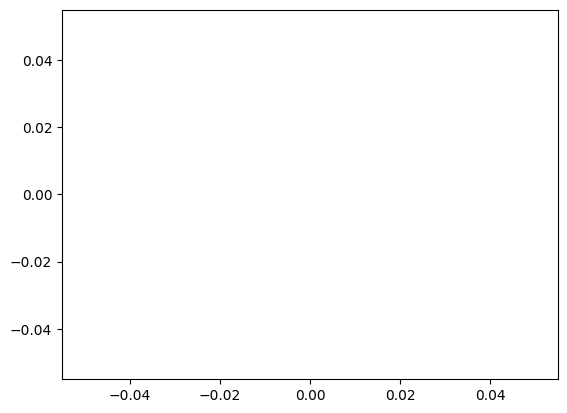

In [41]:
plt.plot(*zip(*lrtoloss.items()))

In [42]:
# train, val, test split
# 80%,   10%, 10%

# train -> optimize your params via gradient descent
# val -> optimize your hyperparams
# test -> held-out set on which to evaluate performance, generalizability of your model. Only allowed few times to risk overfitting on this too.

In [73]:
# build the dataset

def build_dataset(words):

    block_size = 3 # context length: no of chars needed prev to predict next char

    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


In [74]:
import random
random.seed(42)

n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [76]:
# other hyperparameters
block_size = 3
dim_size = 12
num_neurons = 250
num_chars = 27

# parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((num_chars, dim_size), generator=g, requires_grad=True).float()
W1 = torch.randn((block_size * dim_size, num_neurons), generator=g, requires_grad=True).float()
b1 = torch.randn(num_neurons, generator=g, requires_grad=True)
W2 = torch.randn((num_neurons, num_chars), generator=g,  requires_grad=True).float()
b2 = torch.randn(num_chars, generator=g, requires_grad=True)

# training params (hyperparameters)
reg_strength = 0.01
lr = .0005
num_steps = 1500
break_at = 1e-12
batch_size = 64

params = [C, W1, b1, W2, b2]

# num_params
print(sum((p.nelement()) for p in params))

W1.shape


    

16351


torch.Size([36, 250])

In [124]:
def train(X, Y):
    # lrtoloss = {}
    for i in range(num_steps):
        # minibatch
        ix = torch.randint(0, X.shape[0], (batch_size, ))
        yx = Y[ix]
        # forward pass
        emb = C[X[ix]]
        h = torch.tanh(emb.view((emb.shape[0], block_size * dim_size)) @ W1 + b1)
        logits = h @ W2 + b2
        # prob = torch.softmax(logits, 1)
        # loss = -prob[torch.arange(Y.shape[0]), Y].log().mean() # nll
        if i > 0:
            prev_loss = loss
        else:
            prev_loss = None
        loss = F.cross_entropy(logits, yx)
        reg_loss = reg_strength * (W2 ** 2).mean()
        loss += reg_loss
        # print(f"Step {i + 1}: Loss: {loss}")
        lr = 10**-3
        # lr = lrs[i]
        # lrtoloss[lre[i]] = loss.item()
        if prev_loss and abs(prev_loss - loss) < break_at:
            print("Not enough loss happening, breaking...")
            break
        # backward pass
        for p in params:
            p.grad = None

        loss.backward()
        # update
        for p in params:
            p.data += -lr * p.grad

    print(f"Loss post training: {loss}")

train(Xtrain, Ytrain)

Loss post training: 1.9797004461288452


In [125]:
# evaluate
def evaluate(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.shape[0], block_size * dim_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

train_loss = evaluate(Xtrain, Ytrain)
val_loss = evaluate(Xval, Yval)

In [126]:
train_loss, val_loss

(tensor(2.1899, grad_fn=<NllLossBackward0>),
 tensor(2.5182, grad_fn=<NllLossBackward0>))

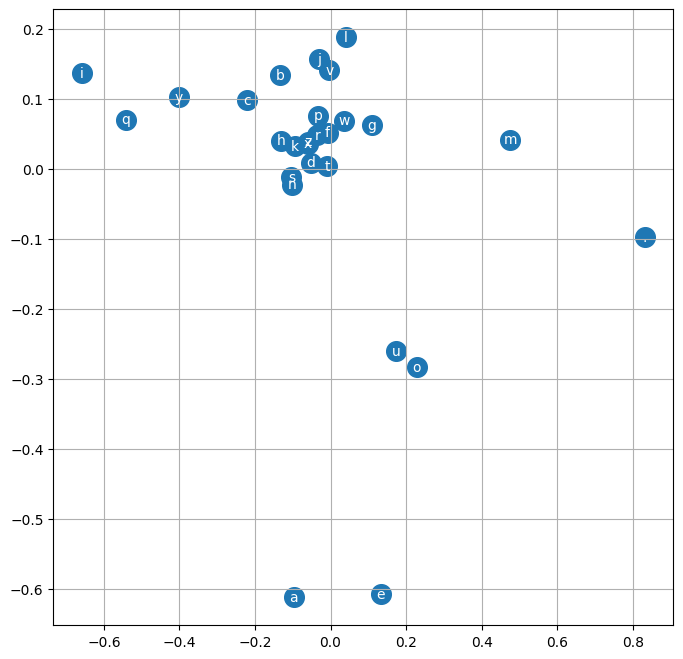

In [127]:
# viz embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [128]:
C.shape

torch.Size([27, 12])

In [129]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1, -1)) @ W1 + b1)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

junide.
janasar.
pallarie.
nai.
jirn.
toleon.
juel.
kalinaa.
zamilenias.
deyah.
rwie.
adsery.
evy.
arterinvelleryn.
dtumi.
phynsleigh.
ani.
cora.
yaelon.
kaelandine.


In [130]:
W1.shape

torch.Size([36, 250])

In [131]:
torch.tensor([context]).sha

AttributeError: 'Tensor' object has no attribute 'sha'

## Makemore: PART 2

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# read words
with open("names.txt", 'r') as f:
    words = f.read().splitlines(keepends=False)

In [3]:
# build char vocab and mapping
chars = sorted(list(set(''.join(words))))

stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocab size: {vocab_size}")


Vocab size: 27


In [4]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y

In [5]:
random_seed = 2147483647
random.seed(random_seed)
g = torch.Generator().manual_seed(random_seed)

In [6]:
# train, val, test split
random.shuffle(words)

train_split = .8; val_split = .1

n1 = int(train_split * len(words))
n2 = int((train_split + val_split) * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [81]:
# build MLP

# MLP structure params
emb_dim_size = 12
hidden_layer_size = 300

# MLP params
C = torch.randn((vocab_size, emb_dim_size), generator=g).float() # represent each character in dim space
W1 = torch.randn((block_size * emb_dim_size, hidden_layer_size), generator=g).float() # weights for hidden layer, for each neuron, it will receive block_size number of i/p, each i/p of dimension dim_size
W1 = W1 * (5/3) / ((block_size * emb_dim_size) ** 0.5) # kiming_init - to "fight the contraction of tanh", preserve gaussian std. -> to resolve tanh saturation
b1 = torch.randn(hidden_layer_size, generator=g).float() # each neuron will have 1-D bias
b1 = b1 * 0.001 # to resolve tanh saturation
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g).float() # weights for output layer, each neuron of hidden layer fully connected to each neuron of output layer
W2 = W2 * 0.01 # to normalize loss at initialization
b2 = torch.randn(vocab_size, generator=g).float() # num_neurons in output layer equal to vocab size, to represent probs for each character
b2 = b2 * 0 # to normalize loss at initialization
params = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

19551


In [82]:
# hyperparams
n_epochs = 200000
batch_size = 32

In [83]:
stepi, lossi = [], []

def train(X: torch.Tensor, Y: torch.Tensor):
    for i in range(n_epochs):
        # forward pass
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
        
        xi = C[X[ix]]
        yi = Y[ix]

        xicat = xi.view(xi.shape[0], block_size * emb_dim_size) # concatenate the vectors to facilitate matmul w/ W1
        h_preact = xicat @ W1 + b1 # hidden layer pre-activation
        h: torch.Tensor = F.tanh(h_preact) # hidden layer # tanh saturation prone. TODO: Read more.
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits)
        loss = F.cross_entropy(logits, yi)

        # backward pass
        #zero-grad
        for p in params:
            p.grad = None
        
        loss.backward()

        #update
        lr = 10 ** -1 if i < 100000 else 10 ** -2
        for p in params:
            p.data += -lr * p.grad
        
        # track stats
        stepi.append(i)
        lossi.append(loss.item())

        # print logs every once in a while
        if i % 10000 == 0:
            print(f"Step {i} / {n_epochs}: Loss: {loss:.4f}")
        
        # Run below code on just first step to see if tanh saturation occurs and if you got any dead neurons
        # plt.hist(h.view(-1).tolist(), bins=50) # sorta uniformly distributed b/w -0.5-0.5, slightly tapering off towards 1/-1, ideally very low examples at extremes
        # plt.hist(h_preact.view(-1).tolist(), bins=50) # should be pretty constricted, look at the x-axis values where the pre-acts are tapering off, they shouldn't be rel. small, ideally below 2
        # plt.figure(figsize=(20, 10))
        # plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white corresponds to examples where h becomes 1/-1, ideally need very few white boxes, if you see an entire white vertical line, thats a dead neuron, very very problematic.
        # break
    print(f"Loss post training: {loss}")

        

train(X_train, Y_train)


/tmp/ipykernel_16164/3304915309.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


Step 0 / 200000: Loss: 3.2670


Step 10000 / 200000: Loss: 2.1851
Step 20000 / 200000: Loss: 2.2768
Step 30000 / 200000: Loss: 2.0473
Step 40000 / 200000: Loss: 1.9482
Step 50000 / 200000: Loss: 1.8759
Step 60000 / 200000: Loss: 1.9266
Step 70000 / 200000: Loss: 2.3350
Step 80000 / 200000: Loss: 1.7527
Step 90000 / 200000: Loss: 2.4476
Step 100000 / 200000: Loss: 1.7695
Step 110000 / 200000: Loss: 2.1749
Step 120000 / 200000: Loss: 2.0172
Step 130000 / 200000: Loss: 2.7008
Step 140000 / 200000: Loss: 1.9047
Step 150000 / 200000: Loss: 1.9501
Step 160000 / 200000: Loss: 1.7587
Step 170000 / 200000: Loss: 1.9427
Step 180000 / 200000: Loss: 2.3339
Step 190000 / 200000: Loss: 1.9075
Loss post training: 2.352978229522705


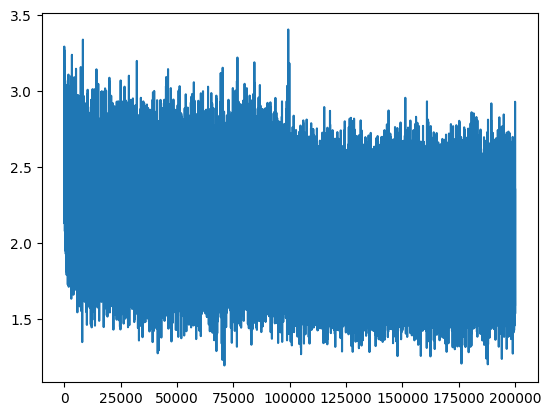

In [84]:
plt.plot(stepi, lossi)

In [16]:
W1

tensor([[ 0.1709,  0.8269,  0.8992,  ...,  0.1804,  2.1570,  0.1267],
        [-0.1460,  1.3890, -0.3706,  ...,  1.0327, -1.5075, -0.3132],
        [ 1.4641,  1.6654,  0.6373,  ..., -1.3728,  0.0895, -0.2641],
        ...,
        [-0.2528, -0.6040, -1.9201,  ...,  1.2785, -0.6945,  0.9667],
        [ 0.8409, -1.2842,  0.5023,  ...,  0.0731, -0.2719, -2.2700],
        [-1.0247,  0.8835, -1.1529,  ..., -0.2901, -0.2698,  0.5494]],
       requires_grad=True)

In [85]:
@torch.no_grad() # decorator prevents gradient tracking
def split_loss(split: str):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], block_size * emb_dim_size)
    h = F.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss = {loss.item()}")

split_loss('train')
split_loss('val')
split_loss('test')




train loss = 2.0085878372192383
val loss = 2.1038553714752197
test loss = 2.0997254848480225


In [86]:
# sample from the model

def sample(num_samples: int = 20):
    for _ in range(num_samples):
        samples = []
        context = [0] * block_size # init with all ...
        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context])]
            embcat = emb.view(1, -1)
            h = F.tanh(embcat @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            samples.append(ix)
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in samples))

sample()


louri.
markota.
kaysi.
jacarlo.
abrik.
bryck.
ori.
jair.
jalanie.
ozeric.
jasiman.
khal.
jerie.
anna.
abrie.
ala.
haihanyla.
tas.
sadeyah.
davious.


/tmp/ipykernel_16164/3918031224.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [33]:
# at initializaiton
# uniform prob
-torch.tensor(1/27.0).log() # ideal loss at init.

tensor(3.2958)

## Pointers to keep in mind

#### 1. Fix softmax being confidently wrong
        If you start with random weights and biases for the output layer, softmax will confidently label the probability of some neurons (i.e, candidate characters) too highly and for others it will label the probs as too low (in order to sum to 1). This becomes problematic when the neurons it chooses (at random, because remember, W2, b2 are torch.randn), are false positives, i.e, they don't have very good probabilities in the true set. 

        This makes the network have very high losses in the first few steps, wherein it tries to converge from the confidently wrong estimates to realistic outputs.

        In the case of language modelling, this can be easily fixed by initializing W2 and b2 as very low floats, in order to squash down this confident behaviour down to the median, which is essentially attributing equal probs to each of the neurons. 
        
        You can observe this by checking how close the loss of the 1st step is to the value of the negative log of (1/num_output_neurons).

### 2. Fix tanh saturation
        